In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [74]:
df=pd.read_csv('/content/ai_job_dataset.csv')

In [75]:
df.head()

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [76]:
df.isnull().sum()

,0
job_id,0
job_title,0
salary_usd,0
salary_currency,0
experience_level,0
employment_type,0
company_location,0
company_size,0
employee_residence,0
remote_ratio,0


In [77]:
for col in df.columns:
  print(f' {col}: {len(df[col].value_counts())}')

 job_id: 15000
 job_title: 20
 salary_usd: 14315
 salary_currency: 3
 experience_level: 4
 employment_type: 4
 company_location: 20
 company_size: 3
 employee_residence: 20
 remote_ratio: 3
 required_skills: 13663
 education_required: 4
 years_experience: 20
 industry: 15
 posting_date: 486
 application_deadline: 543
 job_description_length: 2000
 benefits_score: 51
 company_name: 16


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

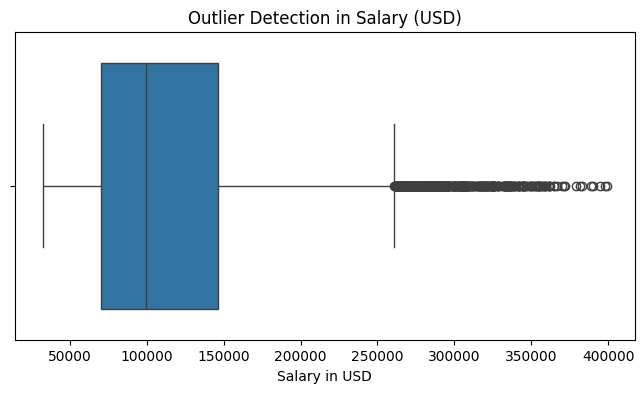

In [79]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['salary_usd'])
plt.title('Outlier Detection in Salary (USD)')
plt.xlabel('Salary in USD')
plt.show()

This step limits the salary_usd values to lie between the 1st and 99th percentiles effectively clipping extreme outliers to reduce their impact on the analysis

In [80]:
# Clip outliers
q1, q99 = df['salary_usd'].quantile([0.01, 0.99])
df['salary_usd'] = df['salary_usd'].clip(q1, q99)

In [81]:
df.drop(['job_id', 'salary_currency'], axis=1, inplace=True)

I used One-Hot Encoding to convert categorical columns into numerical format without introducing false ordinal relationships. This ensures the ANN model can correctly interpret categories as independent features.

OneHotEncoder by default returns a NumPy array, not a DataFrame. If we assign this array directly to df, we lose the original column names and structure

In [82]:
ohe = OneHotEncoder(sparse_output=False, drop='first')

cat_cols = ['job_title', 'experience_level', 'employment_type', 'company_location', 'company_size', 'employee_residence', 'education_required', 'industry', 'company_name']

encoded = ohe.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=df.index)

df['posting_month'] = pd.to_datetime(df['posting_date']).dt.month
df['application_month'] = pd.to_datetime(df['application_deadline']).dt.month
df.drop(columns=['posting_date', 'application_deadline'], inplace=True)
df.drop(columns=cat_cols, inplace=True)
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [83]:
df['required_skills'] = df['required_skills'].str.split(', ')

all_skills = [skill for sublist in df['required_skills'] for skill in sublist]
top_10_skills = pd.Series(all_skills).value_counts().head(10).index.tolist()

for skill in top_10_skills:
    df[f'skill_{skill.replace(" ", "_")}'] = df['required_skills'].apply(lambda x: int(skill in x))

df['skill_count'] = df['required_skills'].apply(len)

df.drop(columns=['required_skills'], inplace=True)

In [84]:
df.head()

,salary_usd,remote_ratio,years_experience,job_description_length,benefits_score,posting_month,application_month,job_title_AI Consultant,job_title_AI Product Manager,job_title_AI Research Scientist,...,skill_SQL,skill_TensorFlow,skill_Kubernetes,skill_Scala,skill_PyTorch,skill_Linux,skill_Git,skill_Java,skill_GCP,skill_count
0,90376.0,50,9,1076,5.9,10,11,0.0,0.0,1.0,...,0,0,1,0,1,1,0,0,0,5
1,61895.0,100,1,1268,5.2,11,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,5
2,152626.0,0,2,1974,9.4,3,4,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,5
3,80215.0,50,7,1345,8.6,12,2,0.0,0.0,0.0,...,1,0,0,1,0,1,0,0,0,4
4,54624.0,100,0,1989,6.6,4,6,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,4


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Columns: 115 entries, salary_usd to skill_count
dtypes: float64(99), int32(2), int64(14)
memory usage: 13.0 MB


Most people earn average salaries. A few earn very high salaries (outliers) which cause poor predictions for lower/mid salary ranges so i applied log transform here log1p means log(1+salary_usd). which safely handles zero or very small salaries too.

StandardScaler works better when data has both positive and negative values or isn't strictly bounded

In [86]:
X = df.drop('salary_usd', axis=1)
y = np.log1p(df['salary_usd'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [87]:
from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor(random_state=42)
model1.fit(X, y)
importances = model1.feature_importances_

feature_importance_df = pd.DataFrame({'feature': X.columns,'importance': importances}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

                           feature  importance
1                 years_experience    0.577297
47    company_location_Switzerland    0.039253
25             experience_level_EX    0.031540
34        company_location_Denmark    0.031238
43         company_location_Norway    0.029832
..                             ...         ...
63  employee_residence_Netherlands    0.000241
55      employee_residence_Denmark    0.000238
58      employee_residence_Germany    0.000230
67       employee_residence_Sweden    0.000210
65    employee_residence_Singapore    0.000200

[114 rows x 2 columns]


In [91]:
important_features = feature_importance_df[feature_importance_df['importance'] >= 0.001]['feature'].tolist()
print(important_features,len(important_features))
X_reduced = X[important_features]

X_scaled = scaler.fit_transform(X_reduced)

['years_experience', 'company_location_Switzerland', 'experience_level_EX', 'company_location_Denmark', 'company_location_Norway', 'company_size_S', 'experience_level_SE', 'experience_level_MI', 'company_location_United States', 'company_size_M', 'company_location_United Kingdom', 'company_location_Singapore', 'company_location_Netherlands', 'job_description_length', 'company_location_Germany', 'company_location_Sweden', 'company_location_France', 'company_location_Canada', 'benefits_score', 'posting_month', 'application_month', 'remote_ratio', 'skill_count', 'company_location_Ireland', 'company_location_Austria', 'company_location_South Korea', 'company_location_China', 'company_location_Israel', 'company_location_Japan', 'company_location_Finland', 'company_location_India', 'skill_Python', 'employment_type_PT', 'employment_type_FL', 'education_required_Master', 'education_required_Bachelor', 'skill_TensorFlow', 'education_required_PhD', 'employment_type_FT', 'skill_SQL', 'skill_Kuber

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

No activation like softmax or sigmoid because we don't want probabilities, we want real-valued salary predictions

In [94]:
model = Sequential([
    # Dense(2048, activation='relu', input_shape=(X_train.shape[1],)),
    # BatchNormalization(),
    # Dropout(0.5),
    # Dense(1024, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.5),
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 512)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,169 (778.00 KB)

 Trainable params: 197,377 (771.00 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [95]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

model.compile(optimizer='adam',loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
mc=ModelCheckpoint('job_model.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, validation_split=0.25, epochs=200, batch_size=64, callbacks=[early_stop,mc], verbose=1)

Epoch 1/200
137/141 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 79.9938 - mae: 8.1172
Epoch 1: val_loss improved from inf to 4.17117, saving model to job_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 78.5554 - mae: 8.0049 - val_loss: 4.1712 - val_mae: 1.8268
Epoch 2/200
137/141 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0319 - mae: 1.5746
Epoch 2: val_loss improved from 4.17117 to 0.30884, saving model to job_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4.0222 - mae: 1.5726 - val_loss: 0.3088 - val_mae: 0.4454
Epoch 3/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0525 - mae: 1.3769
Epoch 3: val_loss did not improve from 0.30884
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.0516 - mae: 1.3768 - val_loss: 0.3379 - val_mae: 0.4663
Epoch 4/200
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6279 - mae: 1.2680
Epoch 4: val_loss did not improve from 0.30884
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.6267 - mae: 1.2678 - val_loss: 0.

In [96]:
loss, mae = model.evaluate(X_test, y_test)
print(f"\nTest Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0221 - mae: 0.1245

Test Loss (MSE): 0.0218
Test MAE: 0.1233


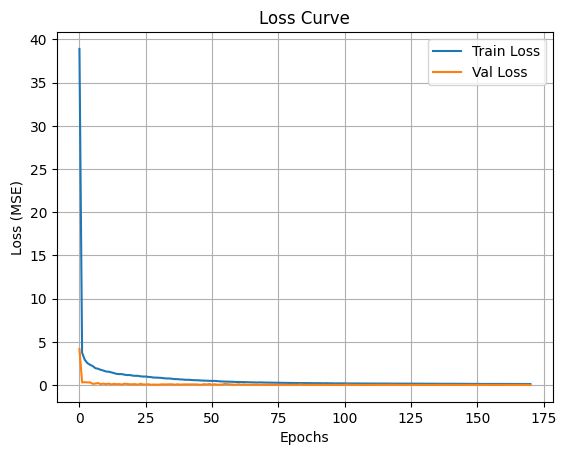

In [97]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

I created a DataFrame to directly compare the predicted salaries with the actual salaries for the first 10 test samples.



In [98]:
y_pred = np.expm1(model.predict(X_test))

comparison_df = pd.DataFrame({'Actual': np.expm1(y_test.values),'Predicted': y_pred.flatten()})
print(comparison_df.head(10))

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
     Actual      Predicted
0  138919.0  144347.359375
1  187208.0  169853.906250
2  158264.0  133949.078125
3  139174.0  170203.656250
4   61622.0   77226.054688
5   90518.0  100857.218750
6   84245.0   69893.031250
7   51038.0   43454.843750
8  105093.0  124660.273438
9   54155.0   70196.304688


In [99]:
y_pred.shape

(3000, 1)

applied the inverse log transformation (using np.expm1) to both the predicted and actual log-salary values to bring them back to the original salary scale. Then, I calculated the R2 score to evaluate how well the model explains the variance in actual salaries

In [100]:
y_pred_log = model.predict(X_test).flatten()
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

from sklearn.metrics import r2_score
print("R² Score:", r2_score(y_test_real, y_pred_real))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R² Score: 0.8829921793970801


model explains 88% of the variance in salaries

In [101]:
y_pred_log.shape

(3000,)

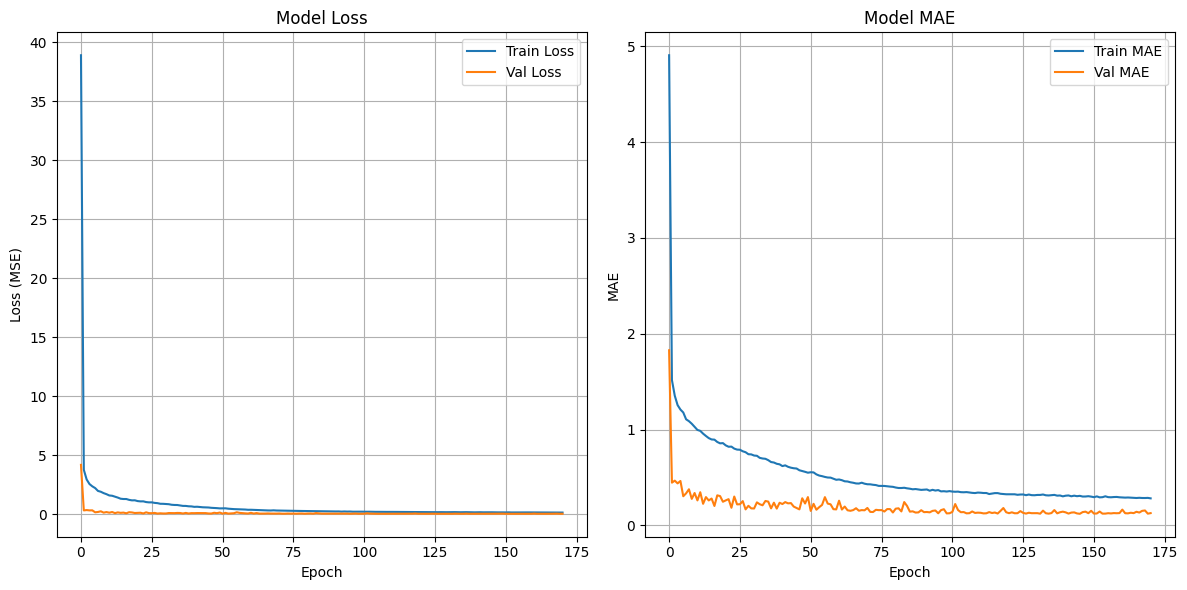

In [102]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()